# Exploration notebook for task selection

In [1]:
# setup
# !make install
# !pip install xgboost

## Load in the data

load from mteb leaderboard:

In [2]:
from pathlib import Path

import pandas as pd
from get_table_from_hf import get_leaderboard_df

results_path = Path("results.csv")
if not results_path.exists():
    get_leaderboard_df(str(results_path))
observed_results = pd.read_csv(str(results_path))

observed_results.head()

/Users/au561649/.virtualenvs/mteb/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Model,Overall,AmazonCounterfactualClassification (en),AmazonPolarityClassification,AmazonReviewsClassification (en),Banking77Classification,EmotionClassification,ImdbClassification,MTOPDomainClassification (en),MTOPIntentClassification (en),...,SICK-R,STS12,STS13,STS14,STS15,STS16,STS17 (en-en),STS22 (en),STSBenchmark,SummEval
0,nvidia/NV-Embed-v1,69.318571,95.12,97.14,55.47,90.34,91.70,97.06,96.51,89.77,...,82.80,76.22,86.30,82.09,87.24,84.77,87.42,69.85,86.14,31.20
1,voyage-large-2-instruct,68.279286,77.60,96.58,50.77,86.96,59.81,96.13,98.86,86.97,...,83.16,76.15,88.49,86.49,91.13,85.68,90.06,66.32,89.22,30.84
2,Linq-AI-Research/Linq-Embed-Mistral,68.174464,84.43,95.70,57.64,87.88,51.82,94.78,96.83,89.57,...,84.31,78.44,88.27,84.49,90.28,87.37,92.68,68.62,88.81,30.98
3,Salesforce/SFR-Embedding-Mistral,67.556964,77.93,95.97,54.35,88.81,50.24,94.79,96.36,86.30,...,82.92,79.47,89.15,84.93,90.74,87.82,92.02,68.36,89.00,31.16
4,gte-Qwen1.5-7B-instruct,67.343750,83.16,96.70,62.17,81.68,54.53,95.58,95.75,84.26,...,79.15,76.52,88.63,83.32,87.50,86.39,87.79,66.40,87.35,31.46


## Task selection

### Approach 1: Leave-one-task-out performance prediction

The assumption here is that tasks which performance is highly predictable from the other tasks are not very informative. We can use this to select a subset of tasks that are most informative.

In [26]:
from multiprocessing import Pool

import xgboost as xgb
from fit_predict import _fit_predict
from sklearn.linear_model import LinearRegression
from tqdm import tqdm


def leave_one_task_out(df: pd.DataFrame, classifer) -> pd.DataFrame:
    """Predicts the performance of a model on a task by training on all other tasks.
    
    Args:
        df: a DataFrame with columns: Model, Overall, and one column for each task.
        classifer: a scikit-learn model that has a fit and predict method. 

    Returns:
        a matrix of predictions for each model and task.
    """
    predictions = pd.DataFrame(columns=df.columns)
    # for task in df.columns:
    task_df = df.drop(["Model", "Overall"], axis=1)
    columns_tqdm = tqdm(task_df.columns)
    for task in columns_tqdm:
        columns_tqdm.set_description(f"Task: {task}")

        with Pool() as p:
            task_predictions = p.starmap(_fit_predict, [(model_i, task, task_df, classifer) for model_i in range(len(df))])
        predictions[task] = list(task_predictions)

    # add the model names and overall scores    
    predictions["Model"] = df["Model"]
    return predictions
    

lr_res_path = Path("performance_predictions_lr.csv")
if not lr_res_path.exists():
    linear_regression = LinearRegression
    predictions_lr = leave_one_task_out(observed_results, linear_regression)
    predictions_lr.to_csv(lr_res_path)

xgboost_res_path = Path("performance_predictions_xgboost.csv")
if not xgboost_res_path.exists():
    xgboost = xgb.XGBRegressor
    predictions_xgb = leave_one_task_out(observed_results, xgboost)
    predictions_xgb.to_csv(xgboost_res_path)

predictions_lr = pd.read_csv(lr_res_path, index_col=0)
predictions_xgb = pd.read_csv(xgboost_res_path, index_col=0)


Task: SummEval: 100%|██████████| 56/56 [17:38<00:00, 18.91s/it]                              


In [27]:
# sanity check
predictions_lr.head()

,Model,Overall,AmazonCounterfactualClassification (en),AmazonPolarityClassification,AmazonReviewsClassification (en),Banking77Classification,EmotionClassification,ImdbClassification,MTOPDomainClassification (en),MTOPIntentClassification (en),...,SICK-R,STS12,STS13,STS14,STS15,STS16,STS17 (en-en),STS22 (en),STSBenchmark,SummEval
0,nvidia/NV-Embed-v1,NaN,95.736202,97.822220,49.636637,86.558289,64.484251,106.610493,99.108188,85.939138,...,79.710658,77.581597,85.418714,83.743345,84.956631,86.042515,90.598890,74.440823,85.808227,35.118196
1,voyage-large-2-instruct,NaN,85.224665,98.735488,55.353100,91.035124,43.863440,93.793490,100.338322,81.338039,...,81.128923,80.179326,89.253050,86.648266,87.934920,85.942066,89.898675,69.225660,88.863819,28.591736
2,Linq-AI-Research/Linq-Embed-Mistral,NaN,78.197368,95.527840,54.379432,90.928704,52.100094,96.884370,99.106360,88.315765,...,83.622245,75.566215,86.247014,85.853505,91.490896,86.229188,91.132502,65.800344,90.017462,32.775555
3,Salesforce/SFR-Embedding-Mistral,NaN,80.011892,93.068056,57.592341,87.967526,52.550178,95.419647,95.269236,85.384277,...,83.016791,79.059569,88.584949,85.062684,91.216295,88.483969,91.847437,68.419151,88.501325,31.417079
4,gte-Qwen1.5-7B-instruct,NaN,81.992975,96.537723,62.017082,81.984545,53.495047,96.779685,96.076919,84.954550,...,79.571411,77.005025,89.196067,83.010895,87.562886,86.478629,88.726843,67.734855,86.605343,31.073949


In [28]:
# sanity check
predictions_xgb.head()

,Model,Overall,AmazonCounterfactualClassification (en),AmazonPolarityClassification,AmazonReviewsClassification (en),Banking77Classification,EmotionClassification,ImdbClassification,MTOPDomainClassification (en),MTOPIntentClassification (en),...,SICK-R,STS12,STS13,STS14,STS15,STS16,STS17 (en-en),STS22 (en),STSBenchmark,SummEval
0,nvidia/NV-Embed-v1,NaN,78.413605,96.913872,54.542782,87.631203,55.156460,94.525986,97.351028,86.951286,...,80.754768,79.574776,85.018524,83.100250,87.991226,85.870651,90.078575,74.744408,85.868881,30.973127
1,voyage-large-2-instruct,NaN,80.595818,96.348465,56.700336,87.468117,51.021961,95.427811,97.576942,85.675323,...,79.966156,80.431229,88.427666,83.747810,89.194077,86.453377,90.694626,69.592606,87.898315,30.779535
2,Linq-AI-Research/Linq-Embed-Mistral,NaN,79.574486,96.348442,55.369728,89.013283,50.962479,94.780586,96.997208,86.835098,...,82.123154,78.163521,89.021355,84.820641,89.624504,87.436867,90.970924,68.609169,86.652260,31.044798
3,Salesforce/SFR-Embedding-Mistral,NaN,83.471855,95.746696,56.724037,88.170311,50.044968,94.759514,96.036766,87.532066,...,83.489639,78.135529,88.508232,84.624535,90.176086,87.466438,91.508759,68.000679,87.068695,31.078989
4,gte-Qwen1.5-7B-instruct,NaN,83.160049,96.699867,62.169048,81.680054,54.530125,95.580231,95.749870,84.260155,...,79.150063,76.520012,88.629562,83.319939,87.499725,86.389786,87.790565,66.400093,87.349609,31.460060


In [29]:
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.stats import zscore

from significant_rank import compute_significant_rank

def calculate_task_scores(predictions: pd.DataFrame, metric) -> pd.DataFrame:
    """Calculate how well the predictions match the observed results.

    Args:
        predictions: a DataFrame with columns: Model, Overall, and one column for each task.
        metric: a function that takes two lists of numbers and returns a single number.

    Returns:
        a DataFrame with a single row that contains the score for each task.
    """
    scores = {}
    for task in predictions.columns:
        if task not in ["Model", "Overall"]:
            scores[task] = metric(predictions[task], observed_results[task])
    return pd.DataFrame(scores, index=[0])

def mse_with_zscore(x, y):
    return mean_squared_error(zscore(x), zscore(y))

def spearman(x, y):
    return spearmanr(x, y)[0]

def pearson(x, y):
    return pearsonr(x, y)[0]

# Calculate the scores for each model and metric

results = {}
for df, mdl_name in zip([predictions_lr, predictions_xgb], ["Linear Regression", "XGBoost"]):
    results[mdl_name] = {}
    for metric, name in zip([mean_squared_error, mse_with_zscore, spearman, pearson], 
                            ["MSE", "MSE with zscore", "Spearman", "Pearson"]):
        results[mdl_name][name] = calculate_task_scores(df, metric)

In [30]:
# print out the 10 most predictable tasks for each model and metric

higher_is_better = ["Spearman", "Pearson", "Pearson with zscore"]

for model, model_results in results.items():
    print(model)
    for metric, metric_results in model_results.items():

        ascending = metric not in higher_is_better
        print(f"{metric} (ascending={ascending})")
        print(metric_results.T.sort_values(by=0, ascending=ascending).head(10))
        print("------\n")


Linear Regression
MSE (ascending=True)
                                  0
STS14                      0.981216
AskUbuntuDupQuestions      1.216323
TwitterURLCorpus           1.262440
BiorxivClusteringP2P       1.450457
StackOverflowDupQuestions  1.530674
STS16                      1.621571
STS13                      1.735421
ArxivClusteringP2P         1.912039
SummEval                   2.006546
MedrxivClusteringP2P       2.033557
------

MSE with zscore (ascending=True)
                                         0
STS14                             0.028116
STS13                             0.057351
StackOverflowDupQuestions         0.068180
NQ                                0.068667
AskUbuntuDupQuestions             0.072197
ArxivClusteringP2P                0.075123
STS16                             0.079436
BiorxivClusteringP2P              0.081859
AmazonPolarityClassification      0.084486
MassiveIntentClassification (en)  0.086144
------

Spearman (ascending=False)
                

### Approach 2: Model agnostic task selection

We consider a task as a feature used to predict the performance of an unseen task. We consider this task a feature reduction problem with specifying the model to be used for prediction. 

Thus we can use simple feature reduction techniques such as:
- removing features with low variance
- removing highly correlated features

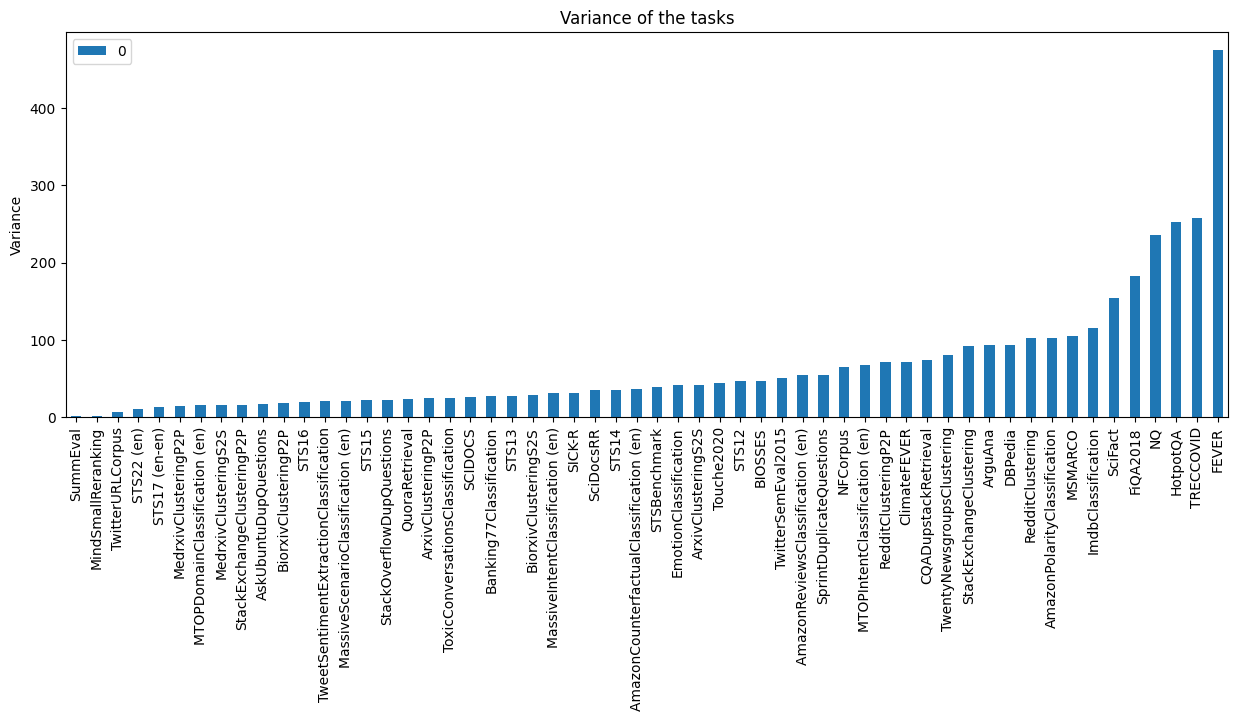

In [33]:
# Estimating variance of the features

from matplotlib import pyplot as plt


def estimate_variance(feature) -> float:
    mean = feature.mean()
    return ((feature - mean) ** 2).mean()

def estimate_variances(df: pd.DataFrame) -> pd.DataFrame:
    variances = {}
    for task in df.columns:
        if task not in ["Model", "Overall"]:
            variances[task] = estimate_variance(df[task])
    return pd.DataFrame(variances, index=[0])

# sorted plot:

variances = estimate_variances(observed_results)

variances.T.sort_values(ascending=True, by=0).plot(kind="bar", figsize=(15, 5))
plt.ylabel("Variance")
plt.title("Variance of the tasks")
plt.show()

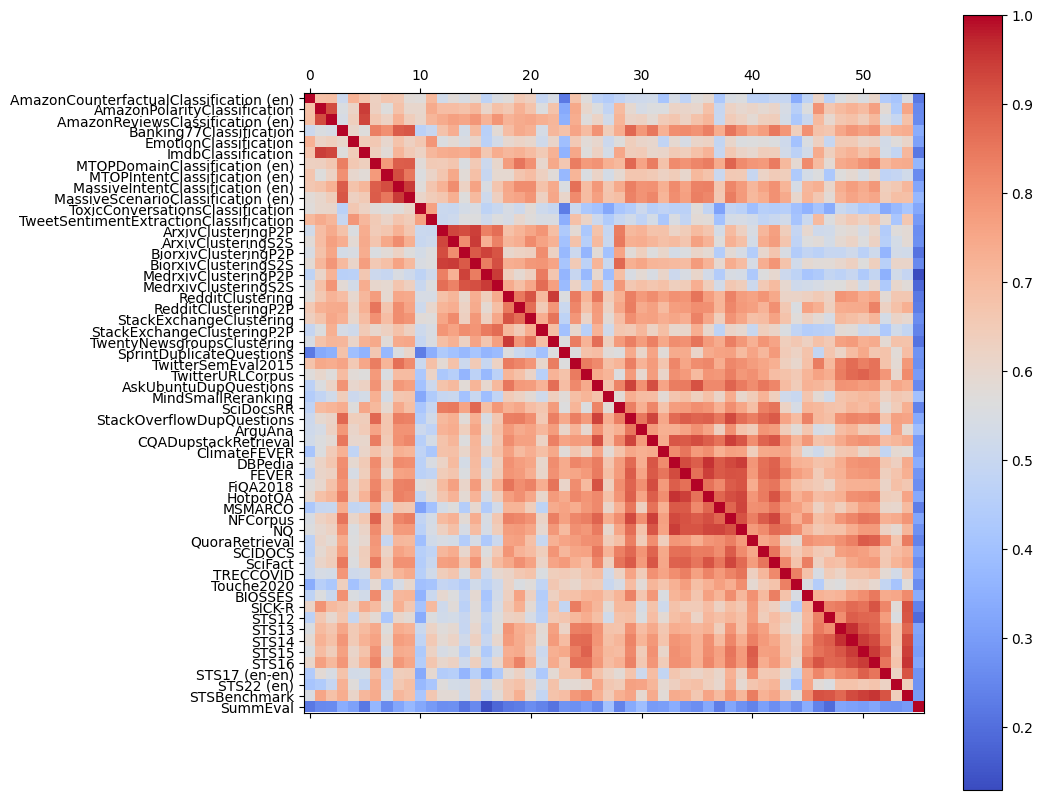

In [60]:
# Correlation matrix (Pearson)

correlation_matrix = observed_results.drop(["Model", "Overall"], axis=1).corr(method="pearson")

# matplotlib with names on the axes
plt.rcParams['figure.figsize'] = [10, 10]
plt.matshow(correlation_matrix, cmap='coolwarm')
# plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.colorbar()

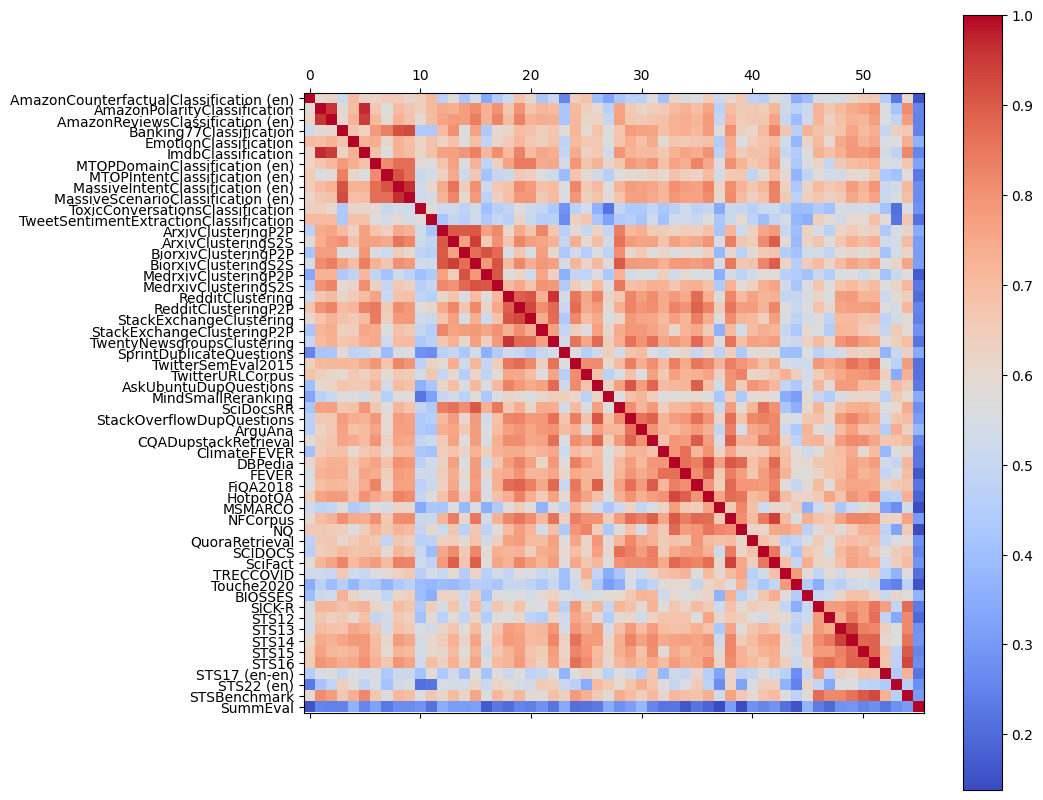

In [61]:
# Correlation matrix (Spearman)

correlation_matrix = observed_results.drop(["Model", "Overall"], axis=1).corr(method="spearman")
plt.matshow(correlation_matrix, cmap='coolwarm')
# plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.colorbar()